<a href="https://colab.research.google.com/github/locemarn/DataScienceWithPython/blob/main/classificacao_aluno_marcelo_nogueira_203214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Análise de Crédito (Give me some credit!)</center></h1>

Neste exercício vamos construir um classificador para prever inadimplência de tomadores de empréstimo. O problema foi apresentado na plataforma Kaggle (https://www.kaggle.com/c/GiveMeSomeCredit), com o prêmio de 5000 USD para o ganhador. Os atributos disponíveis nos dados são descritos abaixo:

<img src="DescricaoAtributos.png">

Segundo as regras, a avaliação do modelo deve ser feita pela métrica AUC, sendo que melhor resultado obtido pelos participantes nos testes foi 0.8695:

<img src="Kaggle_Ranking.png">

Para facilitar, primeiro implementamos cada uma das etapas da Extração de Conhecimento em rotinas separadas, em seguida essas são chamadas abaixo no programa principal.

## 0. Importação de módulos

In [132]:
!pip install scikit-plot

import pandas as pd
# import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings('ignore')

## 1.1. Carga de dados

In [133]:
# Para este problema temos dois arquivos: treino e tete. O arquivo de teste, no entanto, não está rotulado, 
# logo trabalharemos apenas com os dados de treino
def carrega_treino():
    url = "https://raw.githubusercontent.com/brvnl/AplicacoesAprendizadoMaquina/main/cs-training.csv"
    df = pd.read_csv(url)
    df.drop(columns="Unnamed: 0", inplace=True)
    return df

In [134]:
dts = carrega_treino()

dts.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


## 1.2. Análise exploratória

In [135]:
# Para atributos numéricos discretos, esta função conta a quantidade de registros por valor,
# providenciando a distribuição para as duas classes.
def countplot_comparisson(df):
    int_attr = ["age", 
                "NumberOfDependents",
                "NumberOfOpenCreditLinesAndLoans", 
                "NumberRealEstateLoansOrLines", 
                "NumberOfTime30-59DaysPastDueNotWorse", 
                "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTimes90DaysLate"]
    
    for c in int_attr:
        fig2, ax2 = plt.subplots(figsize=(20,8))
        sns.countplot(x=c, hue="SeriousDlqin2yrs", data=df).set_title(c)
        
    return

# Para atributos numéricos contínuos esta função exibe a distribuição dos dados em formato 
# box-plot, um para cada classe.
def boxplot_comparisson(df):
    float_attr = ["MonthlyIncome", 
                  "RevolvingUtilizationOfUnsecuredLines", 
                  "DebtRatio"]
    
    for c in float_attr:
        fig3, ax3 = plt.subplots(figsize=(20,8))
        
        g = sns.boxplot(x="SeriousDlqin2yrs", hue="SeriousDlqin2yrs", y=c, data=df)
        g.set_title(c)
        g.set_yscale("log")
        
# Checa a correlação entre cada um dos atributos (são todos numéricos)
def check_correlation(df): 
    fig, ax = plt.subplots(figsize=(20,8))
    sns.heatmap(
        df.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot = True
    ).set_title('Correlação')
    
    return 

# Exibe informações básicas sobre o dataset. Comente/ descomente as linhas 
# conforme quiser.
def analise_exploratoria(df):
    fig1, ax1 = plt.subplots(figsize=(20,8))
    sns.countplot(x="SeriousDlqin2yrs", data=df).set_title('Balanceamento de Classes')

    #countplot_comparisson(df)
    #boxplot_comparisson(df)
    check_correlation(df)
    
    return

## 1.3 Pré Processamento

In [136]:
# Ajusta a diferença de registros entre as classes
def reamostragem(X, Y):
    smt = SMOTETomek(sampling_strategy='auto')
    X_smt, y_smt = smt.fit_resample(X, Y)

    previous_pos = len(Y[Y["SeriousDlqin2yrs"]==1])
    previous_neg = len(Y[Y["SeriousDlqin2yrs"]==0])
    current_pos = len(y_smt[y_smt==1])
    current_neg = len(y_smt[y_smt==0])
    
    print("INFO* Antes da reamostragem: Pos=%d/ Neg=%d; Após reamostragem: Pos=%d/ Neg=%d." %(previous_pos, previous_neg, current_pos, current_neg))
    
    return (X_smt, y_smt)

# Normaliza os valores numéricos pela média e desvio padrão.
def normalizacao_mean_std(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X


# Esta função deve realizar todas as etapas de pre-processamento antes de calibrar o modelo.
def preprocessamento(df):
    
    # Descar linhas NaN
    #df.dropna(axis=0, how="any", inplace=True)
    
    # Preenche NaNs com a média
    #for c in df.columns:
    #    df[c].fillna((df[c].mean()), inplace=True)
        
    # Preenche NaNs com zero
    for c in df.columns:
        df[c].fillna(0, inplace=True)
    
    # Separando 
    Y = df["SeriousDlqin2yrs"].to_frame()
    X = df.drop(columns="SeriousDlqin2yrs")
    
    # Normalizar atributos independentes
    #X = normalizacao_mean_std(X)

    return (X, Y)

## 2. Amostragem e treino

In [137]:
# Esta função deve reunir todas as etapas para a obtenção do modelo, seja diretamente
# sobre os dados de treino (Hold Out) ou por otimização Validação Cruzada + Grid Search.
# Escolha o método de classificação de sua preferência.
def otimizacao(X_train, Y_train):
    
    # Coloque aqui a inicialização e treino do seu modelo
    
    
    
    
    return model

## 3. Resultados

In [138]:
# Essa função exibe os resultados da classificação pelo modelo gerado. Para tanto, a função
# espera receber um dicionário cuja primeira chave é a fase (Treino, Validação e Teste) e a 
# segunda os dados (actual, pred e pred_prob).
def resultados(res):

    # Medidas de acerto 
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        print(classification_report(res[phase]["actual"], res[phase]["pred"]))
    
    # Matriz de Confusão
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_confusion_matrix(res[phase]["actual"], res[phase]["pred"])
        plt.show()
    
    # Curva ROC-AUC
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_roc_curve(res[phase]["actual"], res[phase]["prob"])
        plt.show()

    return

# Programa Principal

Carregando os dados:

In [139]:
# Carrega os dados para um daframe
df_treino = carrega_treino()
print("INFO* Registros de treino orginais: %d; Colunas: %d." %(df_treino.shape))

INFO* Registros de treino orginais: 150000; Colunas: 11.


Análise exploratória (opcional):

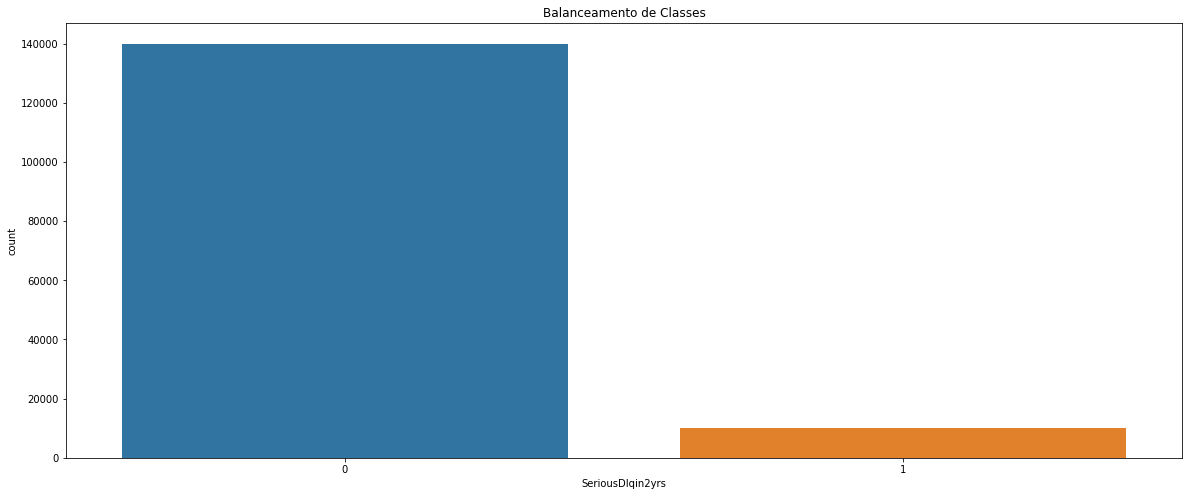

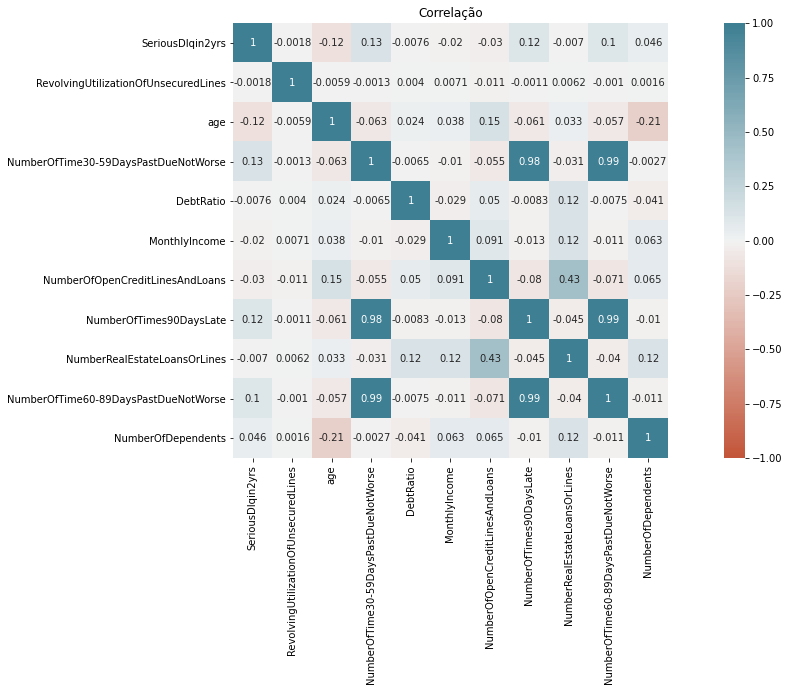

In [140]:
# Exibe características do atributo alvo, dos demais atributos e da relação entre eles.
analise_exploratoria(df_treino)

In [141]:
#
class0 = df_treino['SeriousDlqin2yrs'].value_counts()[0]
class1 = df_treino['SeriousDlqin2yrs'].value_counts()[1]
print("class 0 : {}".format(class0))
print("class 1 : {}".format(class1))
print("delinquency rate: {}".format(class1/(class0+class1)))

class 0 : 139974
class 1 : 10026
delinquency rate: 0.06684


Passoa a serem feitos
* colocar uma mmédia nos dados faltantes na coluna rendimento mensal(MonthlyIncome)
* zerar os dados faltantes na coluna nº de dependentes(NumberOfDependents)
* excluir o registro da linha 65695 que mostra idade menor que 18 anos.

In [142]:
# verificação de valores nullos
df_treino.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

# Tratandos dados faltantes da coluna de rendimento mensal(MonthlyIncome)

Pensei na hipótese de ser mais assertivo e preencher os dados confome média de idades, ou seja, pegaria o min. e máx de idade e separaria em 3 grupos por exemplo. E dentro de cada grupo, já que em tese, conforme maior idade, maior o rendimento mensal. 

Com isso, As colunas de rendimento mensal receberia o valor médio conforme sua idade 

O maior motivo de não ter ido por esse lado é a corelação entre idade e rendimento mensal que está bem baixa e parece não afetar tanto o resultado final, então optei por preencher com a média geral.

In [143]:
media_renda_mensal = df_treino['MonthlyIncome'].mean()

df_treino['MonthlyIncome'] = df_treino['MonthlyIncome'].fillna(media_renda_mensal)



### Também fiz a opção de preencher os dados faltantes da coluna número de dependentes com 0.

In [144]:
df_treino['NumberOfDependents'] = df_treino['NumberOfDependents'].fillna(0)

In [145]:
#sem dados faltantes

df_treino.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Por se tratar de pedido de crédito, fiz a verificação se há menores de 18 anos e a remoção, visto que não é permitido solicitar crédito < 18 anos.

### As idadesacima de 100 anos, decidi manter, pois apesar de incomum, são idades possíveis.


In [146]:
df_treino[df_treino['age'] < 18]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.000000,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.000000,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,6670.221237,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.000000,4,0,0,0,0.0


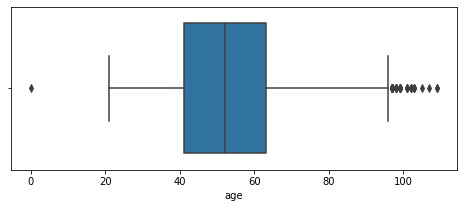

In [147]:
plt.figure(figsize=(8,3))
sns.boxplot(df_treino['age'])
df_treino

In [148]:
df_treino = df_treino.drop(65695)
df_treino[df_treino['age'] < 18]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


Pré-processamento e separação Treino/Teste:

In [149]:
# Executa todas as rotinas de preprocessamento e separa atributo alvo
X, Y = preprocessamento(df_treino)
print("INFO* Registros após preproc: %d; Colunas em X: %d; Colunas em Y: 1." %(X.shape))

# Separa 5% dos dados para teste (+- 5000 registros)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, stratify=Y, shuffle=True)
print("INFO* Registros separados para treino: %d; teste: %d." %(len(y_train), len(y_test)))

INFO* Registros após preproc: 149999; Colunas em X: 10; Colunas em Y: 1.
INFO* Registros separados para treino: 142499; teste: 7500.


Ajuste de balanceamento (opcional):

In [150]:
# Emprega tecnicas de reamostragem para tratar o desbalanceamento de classes
X_train_rs, y_train_rs = reamostragem(X_train, y_train)
print("INFO* Registros de treino após reamostragem: %d linhas, %d colunas." %(X_train_rs.shape))

INFO* Antes da reamostragem: Pos=9525/ Neg=132974; Após reamostragem: Pos=130298/ Neg=130298.
INFO* Registros de treino após reamostragem: 260596 linhas, 10 colunas.


### Rodando 5 tipos de modelos de classificação para verificar qual possui melhor score.
#### Pegando score em roc_ac e matriz de confusão


Calibrando o modelo:

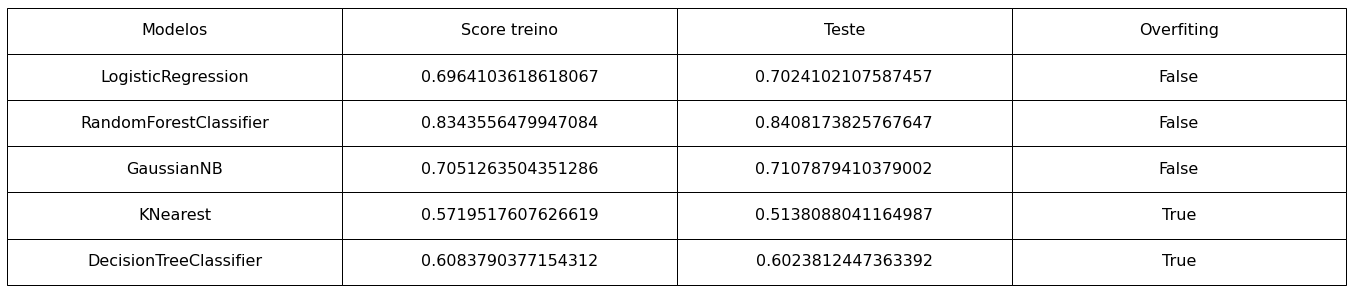

In [159]:
from sklearn.metrics import confusion_matrix

# x_sub_sample = df_treino.drop(columns=['SeriousDlqin2yrs'])
# y_sub_sample = df_treino['SeriousDlqin2yrs']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')
ax.set_aspect(.1)
rows=['']
# cols=["Método", "LogisticRegression", "RandomForestClassifier", "GaussianNB", "KNearest", "DecisionTreeClassifier"]
cols = ["Modelos", "Score treino", "Teste", "Overfiting"]
resultados=[]


classifers = {
        "LogisticRegression" : LogisticRegression(max_iter = 10000),
        "RandomForestClassifier" : RandomForestClassifier(random_state=42, class_weight='balanced'),
        "GaussianNB": GaussianNB(),
        "KNearest": KNeighborsClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier()
    }

# scoring = ['accuracy', 'recall', 'roc_auc']
    
for key ,clf in classifers.items():
    overfiting = False  
    clf.fit(X_test, y_test)
    score = cross_val_score(  clf,
                              X_train,
                              y_train,
                              cv=5,
                              scoring='roc_auc'
                            )
    
    score_test = cross_val_score(  clf,
                              X_test,
                              y_test,
                              cv=5,
                              scoring='roc_auc'
                            )
    
    if (score_test.mean() < score.mean()):
      overfiting = True
      
    
    resultados.append([key, score.mean(), score_test.mean(), overfiting])


table = ax.table(cellText=resultados, colLabels=cols, loc='upper center',cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(4, 25)
    

#### Modelo que obteve melhor score foi o Random Forest Classifier
Optei por usar o modelo sem a técnica de reamostragem acima, pois deu overfitingt em todos os modelos

#### Encontrando os melhores parâmetros para o modelo que obteve melhor score

In [161]:
def find_best_parameter(clf, parameter, X_train, y_train):
    best_model = GridSearchCV(
          clf,
          parameter,
          return_train_score=True
        ).fit(X_train,y_train)
    return best_model.best_estimator_

In [162]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Random Forest
param_grid = { 
    'n_estimators': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5, 7],
    'criterion' :['gini', 'entropy']

}
log_random_forest = find_best_parameter(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, X_train, y_train)

classifers['RandomForestClassifier'] = log_random_forest

classifers['RandomForestClassifier']


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [163]:
random_forest_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

clf.fit(X_train, y_train)
score = cross_val_score(  random_forest_clf,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='roc_auc'
                        )


print('score ->', score.mean())


score -> 0.7793426001131547


#### Com o GRIDSearch, o score ficou menor. Com isso seguirei com os parâmetros básicos.

In [ ]:
X_train, X_test, y_train, y_test

In [173]:
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42, class_weight='balanced'))
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)

# print('y_pred', y_pred)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

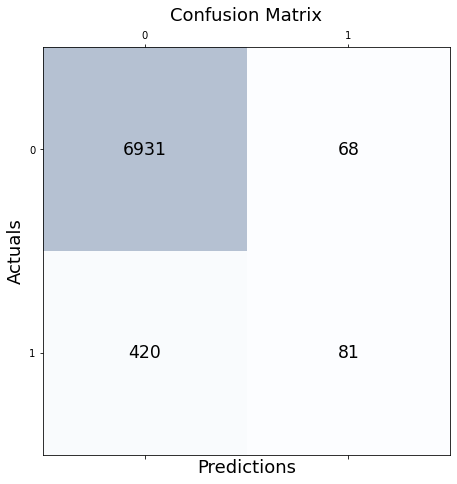

In [174]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Analisando os resultados

In [175]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.94      0.99      0.97      6999
     class 1       0.54      0.16      0.25       501

    accuracy                           0.93      7500
   macro avg       0.74      0.58      0.61      7500
weighted avg       0.92      0.93      0.92      7500



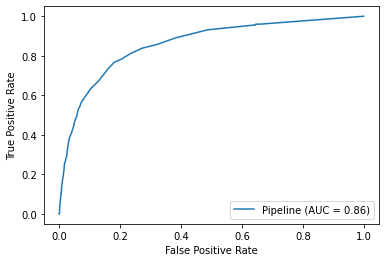

In [176]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm

metrics.plot_roc_curve(pipeline, X_test, y_test) 
plt.show()                                